In [1]:
import os
import numpy as np
import random
import tensorflow as tf
import pathlib
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras import layers, losses, activations, callbacks, optimizers
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
    

2 Physical GPUs, 2 Logical GPUs


In [2]:
print(tf.__version__)
BATCH_SIZE = 16
EPOCHS = 50
USE_GRAYSCALE = False

2.3.1


In [3]:
data_path = '../data'
images_dir = pathlib.Path(f'{data_path}/images')
class_names = np.array(sorted([item.name for item in images_dir.glob('*') if item.name != ".gitkeep" and item.name != ".ipynb_checkpoints"]))
print(class_names)

with open(os.path.join(data_path, 'diff_specs.pickle'), 'rb') as f:
    spec_diff = pickle.load(f)
    
with open(os.path.join(data_path, 'specs.pickle'), 'rb') as f:
    spec_conv, spec_ae = pickle.load(f)

def load(name, spec):
    out_path = os.path.join(data_path, name)
    if not os.path.exists(out_path):
        raise Exception('Path does not exist')
    return tf.data.experimental.load(out_path, spec)

['bad' 'good']


In [4]:
# Load what has been produced using the DenseAE
diff_ae_dense_train_ds = load('diff_ae_dense_train_ds', spec_diff)
diff_ae_dense_val_ds = load('diff_ae_dense_val_ds', spec_diff)
cleaned_ae_dense_train_ds = load('cleaned_ae_dense_train_ds', spec_diff)
cleaned_ae_dense_val_ds = load('cleaned_ae_dense_val_ds', spec_diff)

# Load what has been produced using the ConvAE
diff_ae_conv_train_ds = load('diff_ae_conv_train_ds', spec_diff)
diff_ae_conv_val_ds = load('diff_ae_conv_val_ds', spec_diff)
cleaned_ae_conv_train_ds = load('cleaned_ae_conv_train_ds', spec_diff)
cleaned_ae_conv_val_ds = load('cleaned_ae_conv_val_ds', spec_diff)

# Load original dataset
conv_train_ds = load('conv_train_ds', spec_conv)
conv_val_ds = load('conv_val_ds', spec_conv)

if USE_GRAYSCALE:
    diff_ae_dense_train_ds = diff_ae_dense_train_ds.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))
    diff_ae_dense_val_ds = diff_ae_dense_val_ds.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))
    cleaned_ae_dense_train_ds = cleaned_ae_dense_train_ds.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))
    cleaned_ae_dense_val_ds = cleaned_ae_dense_val_ds.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))
    diff_ae_conv_val_ds = diff_ae_conv_val_ds.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))
    diff_conv_val_ds = diff_conv_val_ds.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))
    cleaned_ae_conv_train_ds = cleaned_ae_conv_train_ds.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))
    cleaned_ae_conv_val_ds = cleaned_ae_conv_val_ds.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))
    
conv_train_ds = conv_train_ds.map(lambda x, y: (x, tf.one_hot(y, 2)))
conv_val_ds = conv_val_ds.map(lambda x, y: (x, tf.one_hot(y, 2)))

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
def configure_for_performance(ds, is_already_batched=False, shuffle=True):
    ds = ds.cache()
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    if is_already_batched:
        ds = ds.unbatch()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

diff_ae_dense_train_ds = configure_for_performance(diff_ae_dense_train_ds)
diff_ae_dense_val_ds = configure_for_performance(diff_ae_dense_val_ds, shuffle=False)
cleaned_ae_dense_train_ds = configure_for_performance(cleaned_ae_dense_train_ds)
cleaned_ae_dense_val_ds = configure_for_performance(cleaned_ae_dense_val_ds, shuffle=False)
diff_ae_conv_train_ds = configure_for_performance(diff_ae_conv_train_ds)
diff_ae_conv_val_ds = configure_for_performance(diff_ae_conv_val_ds, shuffle=False)
cleaned_ae_conv_train_ds = configure_for_performance(cleaned_ae_conv_train_ds)
cleaned_ae_conv_val_ds = configure_for_performance(cleaned_ae_conv_val_ds, shuffle=False)
conv_train_ds = configure_for_performance(conv_train_ds, is_already_batched=True)
conv_val_ds = configure_for_performance(conv_val_ds, is_already_batched=True, shuffle=False)

In [6]:
diff_ae_dense_val_ds.element_spec, conv_val_ds.element_spec

((TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)),
 (TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)))

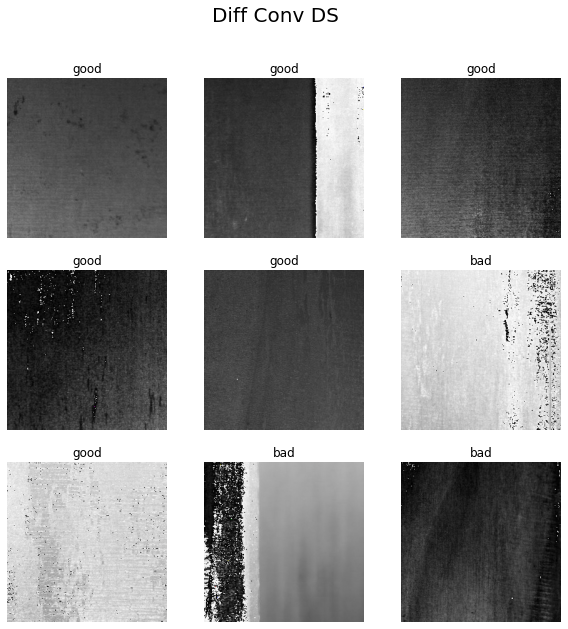

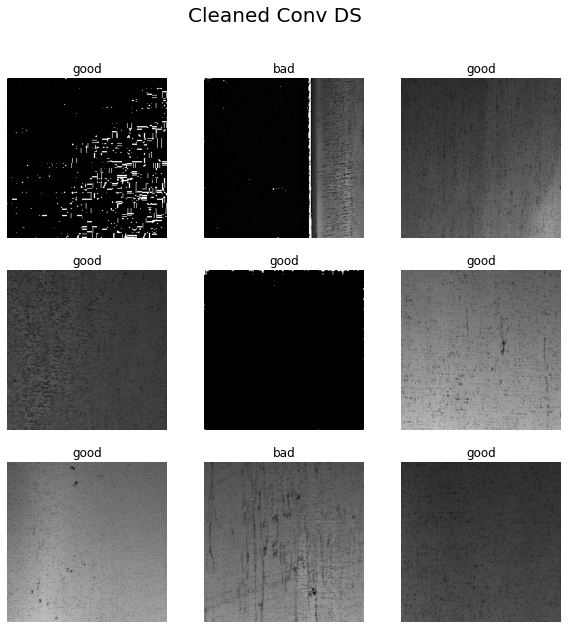

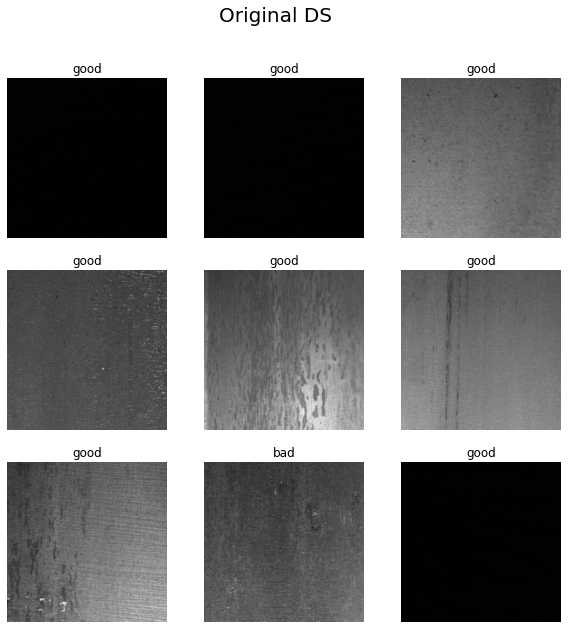

In [7]:
def plot_samples(image_batch, label_batch, title='', grayscale=False):
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle(f'{title} DS', fontsize=20)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        if grayscale:
            plt.imshow(image_batch[i].numpy().astype("uint8"), cmap='gray', vmin=0, vmax=255)
        else:
            plt.imshow(image_batch[i].numpy().astype("uint8"))
        label = label_batch[i]
        plt.title(class_names[tf.argmax(label, axis=0)])
        plt.axis("off")

image_batch, label_batch = next(iter(diff_ae_conv_val_ds)) 
plot_samples(image_batch, label_batch, 'Diff Conv', USE_GRAYSCALE)
image_batch, label_batch = next(iter(cleaned_ae_conv_val_ds)) 
plot_samples(image_batch, label_batch, 'Cleaned Conv', USE_GRAYSCALE)
image_batch, label_batch = next(iter(conv_val_ds)) 
plot_samples(image_batch, label_batch, 'Original', USE_GRAYSCALE)

In [8]:
datasets = dict({
    'diff_ae_dense': (diff_ae_dense_train_ds, diff_ae_dense_val_ds),
    'cleaned_ae_dense': (cleaned_ae_dense_train_ds, cleaned_ae_dense_val_ds),
    'diff_ae_conv': (diff_ae_conv_train_ds, diff_ae_conv_val_ds),
    'cleaned_ae_conv': (cleaned_ae_conv_train_ds, cleaned_ae_conv_val_ds), 
    'original': (conv_train_ds, conv_val_ds)
})

## Classifier

In [9]:
from tensorflow.keras.applications import EfficientNetB2  # we are using effnetb2 because it is closest to the actual image size.
from tensorflow.keras.applications.efficientnet import preprocess_input

class Classifier():
    @staticmethod
    def build(width, height, depth):
        input_shape = (height, width, depth)
        
        inputs = layers.Input(shape=input_shape)
        x = preprocess_input(inputs)
        
        model = EfficientNetB2(
            include_top=False,
            input_tensor=x, 
            weights='imagenet',
            drop_connect_rate=0.3
        )

        model.trainable = False
        
        x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
        x = layers.Dropout(0.3, name="top_dropout")(x)
        outputs = layers.Dense(2, activation='softmax', name="pred")(x)
        
        return tf.keras.Model(inputs, outputs, name="EfficientNet")
        

In [10]:
from datetime import datetime

timestamp = datetime.now().isoformat()
def get_callbacks(name=''):
    outpath = os.path.join('..', 'log', 'classifier', name)
    tensorboard_dir = os.path.join(outpath, f'tensorboard')
    if not os.path.exists(tensorboard_dir):
        os.makedirs(tensorboard_dir)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_dir, histogram_freq=1)

    metrics_dir = os.path.join(outpath, f'metrics')
    if not os.path.exists(metrics_dir):
        os.makedirs(metrics_dir)
    csv_callback = tf.keras.callbacks.CSVLogger(filename=os.path.join(metrics_dir, f'training_log_{timestamp}.csv'))

    checkpoint_dir = os.path.join(outpath, f'checkpoints')
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(verbos=0, 
        filepath=os.path.join(checkpoint_dir, 'weights.{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.hdf5'),
        save_weights_only=True,
        monitor='val_loss',
        mode='auto',
        save_best_only=True,
        save_freq='epoch')

    reduce_lr_plateau_callback = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=3, 
        min_lr=0.00001)
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    return [tensorboard_callback, csv_callback, checkpoint_callback, reduce_lr_plateau_callback, early_stopping]

In [11]:
from sklearn.metrics import confusion_matrix

def plot_accuracy(plot_dir, histories):
    plt.clf()
    plt.figure(figsize=(10,10))
    title = f"Accuracy"
    for name, hist in histories.items():
        plt.plot(hist.history["accuracy"], label=f'{name.title()} train')
        plt.plot(hist.history["val_accuracy"], label=f'{name.title()} validation')
    plt.title(title)
    ax = plt.gca()
    ax.set_xlim([0, 50])
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(plot_dir, f'accuracy_{timestamp}.png'))

def plot_loss(plot_dir, histories):
    plt.clf()
    plt.figure(figsize=(10,10))
    title = f"Loss"
    for name, hist in histories.items():
        plt.plot(hist.history["loss"], label=f'{name.title()} train')
        plt.plot(hist.history["val_loss"], label=f'{name.title()} validation')
    plt.title(title)
    ax = plt.gca()
    ax.set_xlim([0, 50])
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(loc="upper right")
    plt.savefig(os.path.join(plot_dir, f'loss_{timestamp}.png'))
    
def plot_metrics(histories, metrics):
    outpath = os.path.join('..', 'log', 'classifier')
    plot_dir = os.path.join(outpath, f'plots')
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    if 'accuracy' in metrics:
        plot_accuracy(plot_dir, histories)
    if 'loss' in metrics:
        plot_loss(plot_dir, histories)
        

In [12]:
def store_model(classifier, name):
    outpath = os.path.join('..', 'log', 'classifier')
    model_save_dir = os.path.join(outpath, f'model', name)
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)
    classifier.save(os.path.join(model_save_dir, timestamp))

In [13]:
def plot_predictions(dataset, classifier, name):
    evaluation_example = dataset.take(1)
    image_batch = None
    label_batch = None
    for elem in evaluation_example:
        image_batch = elem[0]
        label_batch = elem[1]
    predicted_label = classifier.predict(evaluation_example)
    
    outpath = os.path.join('..', 'log', 'classifier')
    plot_dir = os.path.join(outpath, 'plots')
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    plt.clf()
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle(f'Classifier Results on {name.title()} Data', fontsize=20)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        if USE_GRAYSCALE:
            plt.imshow(image_batch[i].numpy().astype("uint8"), cmap='gray', vmin=0, vmax=255)
        else:
            plt.imshow(image_batch[i].numpy().astype("uint8"))
        label = predicted_label[i]
        label_true = label_batch[i]
        plt.title(f'Predicted: {class_names[tf.argmax(label, axis=0)]}\nActual: {class_names[tf.argmax(label_true, axis=0)]}')
        plt.axis("off")
    fig.savefig(os.path.join(plot_dir, f'predictions_{name}_{timestamp}.png'))



In [14]:
def get_true_labels(ds):
    truelabels = list()
    for (_, label) in ds.as_numpy_iterator():
        for l in label:
            truelabels.append(list(l))
    return truelabels

In [15]:
import seaborn as sns

  
def plot_cm(title, name, plot_dir, cm):
    plt.clf()
    plt.figure(figsize=(10,10))
    total = np.sum(cm)
    tp = cm[0][0]
    fn = cm[0][1]
    fp = cm[1][0]
    tn = cm[1][1]
    tp_o = np.round((tp / total)*100,3)
    fn_o = np.round((fn / total)*100,3)
    fp_o = np.round((fp / total)*100,3)
    tn_o = np.round((tn / total)*100,3)
    tp_c = np.round(max((tp / (tp + fn)), 0.0)*100,3)
    fn_c = np.round(max((fn / (tp + fn)), 0.0)*100,3)
    fp_c = np.round(max((fp / (fp + tn)), 0.0)*100,3)
    tn_c = np.round(max((tn / (fp + tn)), 0.0)*100,3)
    labels = np.array([[
            f'TP\nCount: {tp}\nOverall: {tp_o}%\nTPR: {tp_c}%', 
            f'FN (Type 2)\nCount: {fn}\nOverall: {fn_o}%\nFNR: {fn_c}%'
        ],[
            f'FP (Type 1)\nCount: {fp}\nOverall: {fp_o}%\nFPR: {fp_c}%', 
            f'TN\nCount: {tn}\nOverall: {tn_o}%\nTNR: {tn_c}%'
        ]])
    sns.heatmap(cm, annot=labels, fmt='')
    plt.title(f'Confusion Matrix - {title}')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.savefig(os.path.join(plot_dir, f'cm_{name}_{timestamp}.png'))

In [16]:
from sklearn.metrics import precision_recall_curve, auc

def calculate_pr_curve(true_labels, predicted_labels):
    minority_index = np.argmax(np.unique(list(map(np.argmax, true_labels)), return_counts=True)[1])
    precision, recall, threshold = precision_recall_curve(list(map(np.argmax, true_labels)), predicted_labels[:,minority_index])
    _auc = auc(recall, precision)
    return precision, recall, threshold, _auc

def plot_prc(data: list):
    plt.clf()
    plt.figure(figsize=(10,10))
    for label_data, recall, precision in data:
        plt.step(recall, precision, where='post', label='\n'.join(label_data), linewidth=2)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.legend(loc="lower left")
    plt.grid(True)
    ax = plt.gca()
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    plt.title('Precision Recall Curve')
    #plt.show()
    outpath = os.path.join('..', 'log', 'classifier')
    plot_dir = os.path.join(outpath, 'plots')
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    plt.savefig(os.path.join(plot_dir, f'prc_{timestamp}.png'))

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score

def calculate_roc_curve(true_labels, predicted_labels):
    return roc_curve(true_labels, predicted_labels)

def plot_roc(data: list):
    plt.clf()
    plt.figure(figsize=(10,10))
    for fp, tp, label_data in data:
        plt.plot(100*fp, 100*tp, label='\n'.join(label_data), linewidth=2)
    plt.plot([0, 100], [0, 100], 'g--', label='Random', linewidth=2)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.legend(loc="lower right")
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.title('Receiver Operating Characteristic Curve')
    #plt.show()
    outpath = os.path.join('..', 'log', 'classifier')
    plot_dir = os.path.join(outpath, 'plots')
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    plt.savefig(os.path.join(plot_dir, f'roc_{timestamp}.png'))

    

## Training

Training diff_ae_dense
Epoch 1/50
  1/355 [..............................] - ETA: 0s - loss: 0.7736 - accuracy: 0.2500WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
355/355 [==============================] - 29s 82ms/step - loss: 0.5917 - accuracy: 0.8372 - val_loss: 0.5731 - val_accuracy: 0.8652
Epoch 2/50
355/355 [==============================] - 27s 75ms/step - loss: 0.5708 - accuracy: 0.8714 - val_loss: 0.5650 - val_accuracy: 0.8836
Epoch 3/50
355/355 [==============================] - 27s 75ms/step - loss: 0.5669 - accuracy: 0.8788 - val_loss: 0.5609 - val_accuracy: 0.8906
Epoch 4/50
355/355 [==============================] - 27s 76ms/step - loss: 0.5640 - accuracy: 0.8829 - val_loss: 0.5574 - val_accuracy: 0.8956
Epoch 5/50
355/355 [===================

<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

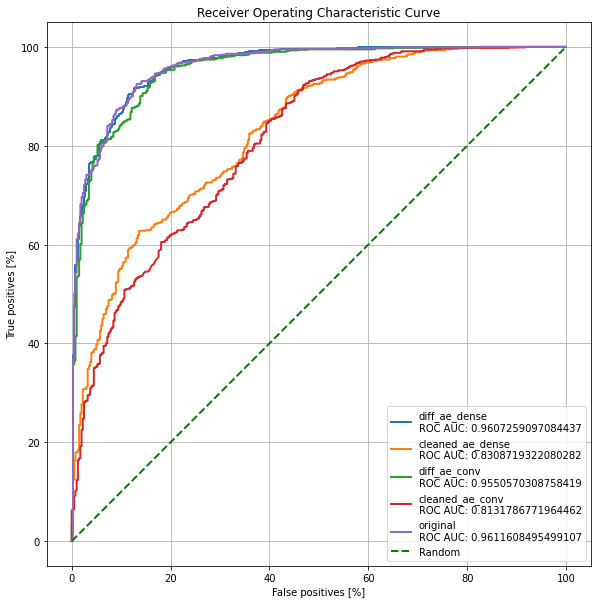

In [18]:
histories = dict()
prc_data = list()
roc_data = list()
outpath = os.path.join('..', 'log', 'classifier')
plot_dir = os.path.join(outpath, 'plots')
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
for k, dataset in datasets.items():
    print(f'Training {k}')
    classifier = Classifier.build(256, 256, 1 if USE_GRAYSCALE else 3) # pretrained models are usually trained on rgb and cannot deal with grayscale. we will alter the data.
    opt = optimizers.Adam(lr=1e-3)
    ls=losses.BinaryCrossentropy(from_logits=True)
    classifier.compile(optimizer=opt, loss=ls, metrics=['accuracy'])
    history = classifier.fit(
        dataset[0],
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=dataset[1],
        shuffle=True,
        callbacks=get_callbacks(k)
    )
    histories[k] = history
    # plot predictions
    plot_predictions(dataset[1], classifier, k)
    prediction = classifier.predict(datasets[k][1])
    truelabel = get_true_labels(dataset[1])
    # plot cm
    plot_cm(k, k, plot_dir, confusion_matrix(list(map(np.argmax, truelabel)), list(map(np.argmax, prediction))))
    # calculate prc
    precision, recall, threshold, _auc = calculate_pr_curve(truelabel, prediction)
    prc_data.append(([f'{k}', f'AUC: {_auc}'], recall, precision))
    # calculate roc
    index = np.argmax(np.unique(list(map(np.argmax, truelabel)), return_counts=True)[1])
    fp, tp, _ = calculate_roc_curve(list(map(np.argmax, truelabel)), prediction[:, index])
    rauc = roc_auc_score(list(map(np.argmax, truelabel)), prediction[:, index])
    roc_data.append((fp, tp, [f'{k}', f'ROC AUC: {rauc}']))
    # store model
    store_model(classifier, k)
plot_metrics(histories, ['accuracy', 'loss'])
plot_prc(prc_data)
plot_roc(roc_data)

In [19]:
!rm run.tar.gz

rm: cannot remove 'run.tar.gz': No such file or directory


In [20]:
!tar -czf run.tar.gz ../log/classifier/plots

tar: Removing leading `../' from member names
